In [31]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
words = open('names.txt', 'r').read().splitlines();
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [33]:
chars = sorted(set(''.join(words)));
stoi = {s:i + 1 for i,s in enumerate(chars)}
stoi['.'] = 0;
itos = {i:s for s,i in  stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [34]:
def build_dataset(words):
    block_size= 3;
    X,Y = [], [];
    for w in words[:]:
        #print(w);
        context = [0]  * block_size;
        for ch in w + '.':
       
            ix = stoi[ch]
            X.append(context);1
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix];
        
    X = torch.tensor(X);
    Y = torch.tensor(Y);
    return X,Y

import random
random.seed(42);
random.shuffle(words);
n1 = int(0.8 * len(words));
n2 = int(0.9 * len(words));
Xtr, Ytr = build_dataset(words[:n1]);
Xdev, Ydev = build_dataset(words[:n2])
Xte, Yte = build_dataset(words[n2:])
block_size = 3;
vocab_size = len(itos)

Xtr

    

tensor([[ 0,  0,  0],
        [ 0,  0, 25],
        [ 0, 25, 21],
        ...,
        [15, 12,  4],
        [12,  4,  1],
        [ 4,  1, 14]])

In [ ]:
#we want logits to be close to zero
#the reason for this is at the beginning we dont know anything 
#so we assume each character has equal likelihood to appear
#logits closer to zero make the probabilty closer to uniform distribution
#Tahs why mulipty W2 by some very lagre no and bb 0

n_embd= 10;
n_hidden =200# no of neurons
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd))
W1 = torch.randn((n_embd * block_size, n_hidden), generator = g) * (5/3) / ((n_embd * block_size) ** 2)
#b1 = torch.randn(n_hidden, generator=g)* 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bmean_running = torch.zeros((1, n_hidden))
bstd_running = torch.ones((1, n_hidden))
parameters = [C, W1,W2, b2, bnbias, bngain]
for p in parameters:
    p.requires_grad =True;



In [ ]:
max_steps = 20000
batch_size = 32;
lossi = [];
for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    emb = C[Xb];
    embcat = emb.view(emb.shape[0], - 1);
    hpreact = embcat@W1 
    # By subtracting the mean and dividing by the standard deviation, 
    # you are guaranteeing that the distribution of hpreact is centered at 0 with a spread of 1.
    #which emsures that your valeus fall between 1 and -1 when they hit the tanh function
# Think of the normalization step (x - mean) / std as a "Rough Reset." It aggressively forces every single neuron into a narrow, centered box.
# bngain and bnbias are the "Fine-Tuning" knobs. They allow the network to say:
# "Thanks for centering this for me so I don't saturate, but actually, I've learned that this specific feature
# is more useful if it's shifted slightly to the right."
# Without these two parameters, you are telling the network: "You must use a Mean 0, Std 1 distribution 
# for every single hidden layer, no matter what." That limits the "expressive power" of your model.
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / (bnstdi) + bnbias
    with torch.no_grad():
        bmean_running = 0.999 * bmean_running + 0.001 * bnmeani
        bstd_running = 0.999 * bstd_running + 0.001 * bnstdi
    h = torch.tanh(hpreact)
    logits = h@W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward();
    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data+= -lr * (p.grad)
    lossi.append(loss.log10().item())
    
print(loss)

tensor(2.1284, grad_fn=<NllLossBackward0>)


In [ ]:

#We do this  i.e calculate bmean and bstd once and use it in the forward pass
# this is static and wont change

#this is explicit caliberation
#We dont really need it since we are maintaining running mean and std
with torch.no_grad():
    emb = C[Xtr];
    embcat = emb.view(emb.shape[0],-1, )
    hpreact = embcat @ W1 
    bnmean = hpreact.mean(0, keepdim = True)
    bnstd = hpreact.std(0, keepdim=True)

In [ ]:
@torch.no_grad
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test':(Xte, Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], - 1)
    hpreact = embcat @W1 
    hpreact = bngain * (hpreact - bmean_running) / (bstd_running) + bnbias
    h = torch.tanh(hpreact)
    logits = h @W2 + b2
    loss = F.cross_entropy(logits, y);
    print(split, loss.item())
    
    
split_loss('train')
split_loss('val')
    

train 2.199812650680542
val 2.200542449951172


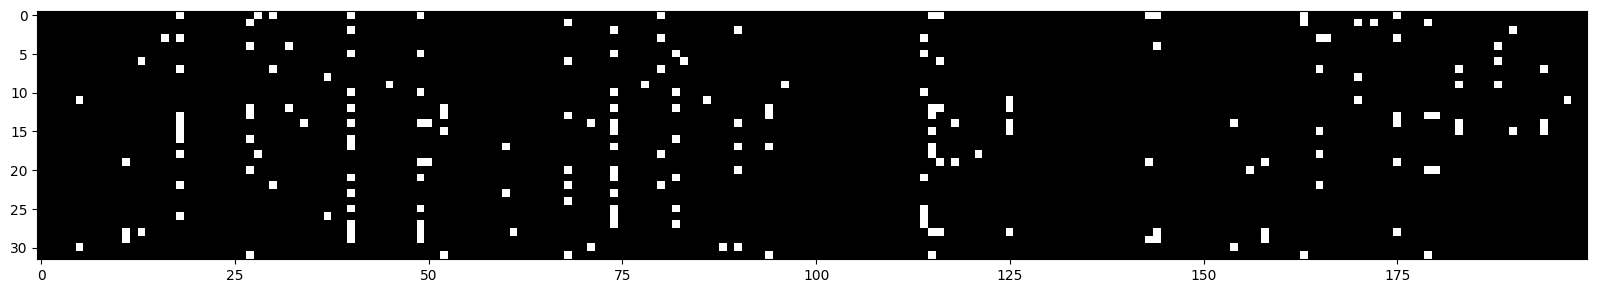

In [38]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap = 'gray',interpolation='nearest')

(array([240., 112., 113.,  77.,  82.,  69.,  77.,  80.,  96.,  80.,  94.,
         82., 122., 119., 117., 113., 129., 160., 132., 170., 159., 172.,
        190., 232., 264., 229., 224., 204., 176., 155., 149., 160., 117.,
        144., 104., 114., 115., 102.,  81.,  80.,  72.,  84.,  74.,  89.,
         86.,  88.,  87.,  95., 101., 189.]),
 array([-9.99998391e-01, -9.59999679e-01, -9.20000968e-01, -8.80002257e-01,
        -8.40003545e-01, -8.00004834e-01, -7.60006123e-01, -7.20007411e-01,
        -6.80008700e-01, -6.40009989e-01, -6.00011277e-01, -5.60012566e-01,
        -5.20013855e-01, -4.80015143e-01, -4.40016432e-01, -4.00017720e-01,
        -3.60019009e-01, -3.20020298e-01, -2.80021586e-01, -2.40022875e-01,
        -2.00024164e-01, -1.60025452e-01, -1.20026741e-01, -8.00280297e-02,
        -4.00293183e-02, -3.06069851e-05,  3.99681044e-02,  7.99668157e-02,
         1.19965527e-01,  1.59964238e-01,  1.99962950e-01,  2.39961661e-01,
         2.79960372e-01,  3.19959084e-01,  3.59957

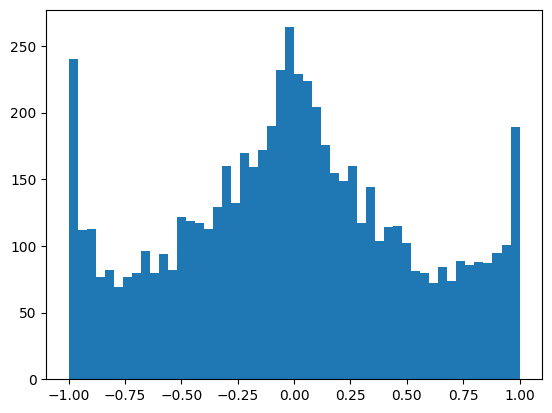

In [39]:
plt.hist(h.view(-1).tolist(), 50)

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00,
        1.000e+00, 4.000e+00, 8.000e+00, 2.000e+00, 1.000e+01, 5.000e+00,
        2.000e+00, 9.000e+00, 1.200e+01, 1.800e+01, 2.000e+01, 2.400e+01,
        2.400e+01, 4.200e+01, 7.100e+01, 7.600e+01, 1.100e+02, 1.380e+02,
        1.840e+02, 2.950e+02, 4.950e+02, 7.910e+02, 1.292e+03, 9.910e+02,
        5.990e+02, 3.260e+02, 2.320e+02, 1.860e+02, 1.120e+02, 7.500e+01,
        6.400e+01, 4.600e+01, 2.900e+01, 3.000e+01, 1.100e+01, 1.000e+01,
        1.600e+01, 9.000e+00, 7.000e+00, 3.000e+00, 4.000e+00, 4.000e+00,
        6.000e+00, 3.000e+00]),
 array([-7.01461458, -6.77063993, -6.52666529, -6.28269064, -6.03871599,
        -5.79474134, -5.5507667 , -5.30679205, -5.0628174 , -4.81884275,
        -4.57486811, -4.33089346, -4.08691881, -3.84294416, -3.59896952,
        -3.35499487, -3.11102022, -2.86704557, -2.62307093, -2.37909628,
        -2.13512163, -1.89114698, -1.64717234, -1.40319769, -1.15922304,
        -0.

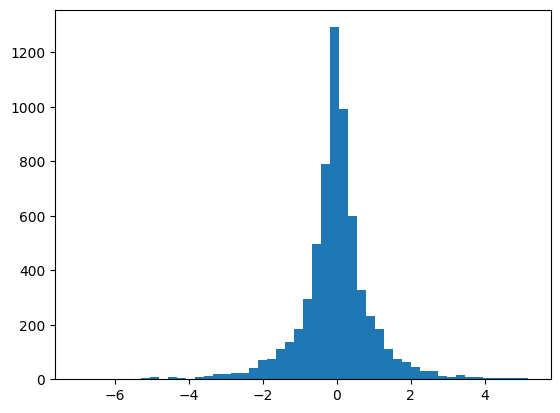

In [40]:
plt.hist(hpreact.view(-1).tolist(), 50)

In [ ]:
# #The issue that these 2 graphs highlight is the following
# the first graph shows the h after perfoming tanh and we can see that a lot of values
# are squashed to either -1 or 1
# this is very bad since this means that the gradiant would be 0
# meaning if we have incoming gradients they would just cancel at this layer

# Similarly we also want h to be close to zero as well due to the vanishing gradient problem
# hence we also multiply w1 and b1 by very small value


In [ ]:
# # Now lets look at how to scale these w
# This code is a demonstration of Variance Preservation.

# You are manually implementing a simplified version of Xavier Initialization. 
# The goal is to ensure that as data flows through the network, it doesn't "explode" (get huge) or "vanish" (shrink to zero).
# Basically we are trying to preserve the original distribution of the input
x = torch.randn(1000, 10);
w = torch.randn(10, 200) / (10 ** 0.5);
y = x @ w;
print(x.mean(), x.std());
print(y.mean(), y.std());

tensor(-0.0254) tensor(1.0012)
tensor(0.0003) tensor(1.0123)


#Refactoring our code and making it more Like pyotorch functions

In [ ]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randint((fan_in, fan_out), generator=g) / fan_in **0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @self.weight;
        if self.bias is not None:
            self.out += self.bias
        return self.out;
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps;
        self.momentum = momentum
        self.training = None
        #paramaters which are trainable
        self.gamma = torch.ones(dim);
        self.beta = torch.zeros(dim);
        
        #we also maintain running mean and variance which in pytorch terminology are known as buffers
        